# Molecular Formulas

In cheminformatics, the typical way of representing a molecule is with a SMILES string such as `CCO` for ethanol. A SMILES string can be converted into a molecular graph which describes which atoms are attached to each other using which bond types. Molecular graphs are very useful for determining molecular structure and related properties.

However, there are still cases where the molecular formula such as C<sub>2</sub>H<sub>6</sub>O is useful. For example, the molecular formula is sufficient to determine the molecular mass, to calculate the predicted results from an elemental analysis, balancing chemical equations, or simply to get a sense for the elemental composition of a given molecule. One of the best-known chemical equations is photosynthesis, presented here.

I'm working on a blog post where I needed to calculate the molecular formula including isotopes. I was unable to find a package that produced molecular formulas including isotopes from SMILES strings, so I wrote a function to do so. (I tried [chemparse](https://pypi.org/project/chemparse/) and did not succeed.)

In [1]:
# !pip install rdkit

In [2]:
from collections import defaultdict
from IPython.display import display, Markdown

from rdkit import Chem

## Set up

Because RDKit excludes hydrogen atoms by default, but we want to include hydrogens in our molecular formula, we tell RDKit to add hydrogens.

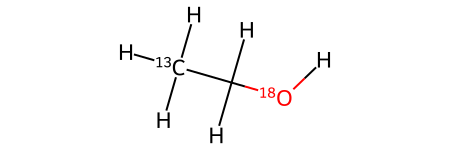

In [3]:
# Ethanol with isotopes
sml = "[13CH3]C[18OH]"
mol = Chem.AddHs(Chem.MolFromSmiles(sml))
mol

The RDKit does not include a composition function to give the number of each element (including isotopes if desired) in a molecule, so we make one here. It's based on an [algorithm suggested by @IchiruTake](https://github.com/rdkit/rdkit/discussions/5339).

In [4]:
def composition(
        molecule: Chem.Mol,
        isotopes: bool = False,
        ):
    """Get the composition of an RDKit molecule:
    Atomic counts, including hydrogen atoms, and isotopes if requested.
    For example, ethanol (SMILES [13C](H)(H)(H)CO, formula C2H6O) returns:
      if isotopes = False (default): {'C': 2, 'O': 1, 'H': 6}.
      if isotopes = True: {'C': {13: 1, 0: 1}, 'O': {0: 1}, 'H': {0: 6}}.

    :param molecule: The RDKit molecule to analyze
    :param isotopes: Whether to include the isotope of each atom
    :returns: if isotopes = False (default): a dictionary of element:count entries;
              if isotopes = True: a nested dictionary of element:isotope:count entries.
    """
    # Check that there is a valid molecule
    if not molecule:
        return

    # Add hydrogen atoms--RDKit excludes them by default
    molecule = Chem.AddHs(molecule)
    comp = defaultdict(lambda: 0)

    # Get atom counts
    for atom in molecule.GetAtoms():
        element_symbol = atom.GetSymbol()
        # If isotopes not requested, simply count the number of atoms of each element
        if not isotopes:
            comp[element_symbol] += 1
        # If isotopes requested, count the number of each isotope of each element
        else:
            isotope = atom.GetIsotope()
            try:
                comp[element_symbol][isotope] += 1
            except:
                comp[element_symbol] = defaultdict(lambda: 0)
                comp[element_symbol][isotope] += 1
    return comp

In [5]:
composition(mol, isotopes=False)

defaultdict(<function __main__.composition.<locals>.<lambda>()>,
            {'C': 2, 'O': 1, 'H': 6})

In [6]:
composition(mol, isotopes=True)

defaultdict(<function __main__.composition.<locals>.<lambda>()>,
            {'C': defaultdict(<function __main__.composition.<locals>.<lambda>()>,
                         {13: 1, 0: 1}),
             'O': defaultdict(<function __main__.composition.<locals>.<lambda>()>,
                         {18: 1}),
             'H': defaultdict(<function __main__.composition.<locals>.<lambda>()>,
                         {0: 6})})

Now that we have the count of each element (with isotopes if desired) in the molecule, we can build the molecular formula. Because of the superscripts for isotopes, and subscripts for counts, we need a formatting language. Our mol_to_formatted_formula() provides a dictionary with two options:
- [Markdown](https://en.wikipedia.org/wiki/Markdown), which is commonly converted to HTML. Here the only formatting used are the HTML tags for superscripts and subscripts, so the outputs are valid HTML as well.
- [LaTeX](https://en.wikipedia.org/wiki/LaTeX), which is commonly used for technical papers. One difficulty was that LaTeX would overlap a subscript and a superscript that immediately followed it, so we add a small amount of horizontal space using an empty group `{}`.

In [7]:
def mol_to_formatted_formula(mol, isotopes=False):
    if mol is not None:
        comp = composition(mol, isotopes)

        formula = {'markdown': "", 'latex': ""}

        if isotopes:
            isotopes_dict = defaultdict(lambda: defaultdict(str))
            subscripts = defaultdict(lambda: defaultdict(int))
            superscripts = defaultdict(list)

            for element, counts in comp.items():
                for isotope, count in counts.items():
                    if count > 1:
                        subscripts[element][isotope] = count
                    if isotope != 0:
                        superscripts[element].append(isotope)

                    isotopes_dict[element][isotope] = 1
                # Sort the element's isotopes from lowest to highest
                superscripts[element].sort()

            last_item_is_subscript = False
            sorted_element_keys = sorted(isotopes_dict.keys())
            for element in sorted_element_keys:
                isotope_count_pairs = isotopes_dict[element]
                # Sort the element's isotopes from lowest to highest
                sorted_isotope_keys = sorted(isotope_count_pairs.keys())
                for isotope in sorted_isotope_keys:
                    if element in superscripts:
                        if isotope in superscripts[element]:
                            formula["markdown"] += f"<sup>{isotope}</sup>"

                            # If superscript immediately follows subscript, 
                            # add a small amount of horizontal space using an empty group {}
                            # to prevent them from vertically overlapping
                            if last_item_is_subscript:
                                formula["latex"] += "{}"
                            formula["latex"] += "^{{{}}}".format(isotope)
                            last_item_is_subscript = False
                    formula["markdown"] += element
                    formula["latex"] += element
                    last_item_is_subscript = False
                    if element in subscripts:
                        if isotope in subscripts[element]:
                            isotope_count = subscripts[element][isotope]
                            formula["markdown"] += f"<sub>{isotope_count}</sub>"
                            formula["latex"] += "_{{{}}}".format(isotope_count)
                        last_item_is_subscript = True
            # Add beginning and ending dollar signs to LaTeX formula
            formula["latex"] = "$" + formula["latex"] + "$"
        else:
            # Handling the case when isotopes is False
            sorted_element_keys = sorted(comp.keys())

            for element in sorted_element_keys:
                count = comp[element]
                formula["markdown"] += element
                formula["latex"] += element
                if count > 1:
                    formula["markdown"] += f"<sub>{count}</sub>"
                    formula["latex"] += "_{{{}}}".format(count)
            formula["latex"] = "$" + formula["latex"] + "$"

        return formula
    else:
        return "Invalid SMILES"

Here's the Markdown for our isotopic ethanol molecule:

In [8]:
isotope_formula_markdown = mol_to_formatted_formula(mol, isotopes=True)["markdown"]
isotope_formula_markdown

'C<sup>13</sup>CH<sub>6</sub><sup>18</sup>O'

and we display it as Markdown using that function:

In [9]:
Markdown(isotope_formula_markdown)

C<sup>13</sup>CH<sub>6</sub><sup>18</sup>O

Here's the LaTeX version:

In [10]:
isotope_formula_latex = mol_to_formatted_formula(mol, isotopes=True)["latex"]
isotope_formula_latex

'$C^{13}CH_{6}{}^{18}O$'

which can also be displayed using the Markdown function:

In [11]:
Markdown(isotope_formula_latex)

$C^{13}CH_{6}{}^{18}O$

To go directly from a SMILES string to a formula, we can use this utility function `smiles_to_formatted_formula()`:

In [12]:
def smiles_to_formatted_formula(smiles, isotopes=False):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        return mol_to_formatted_formula(mol, isotopes=isotopes)

In [13]:
isotope_formula_latex_from_smiles = smiles_to_formatted_formula(sml, isotopes=True)["latex"]
Markdown(isotope_formula_latex_from_smiles)

$C^{13}CH_{6}{}^{18}O$

LaTeX italicizes letters by default, so we can use the [LaTeX `\mathrm`](https://www.tutorialspoint.com/tex_commands/mathrm.htm) to make them non-italicized. (The C-style string substitution using `%` was necessary instead of f-string `{variable}` or `{}.format(variable)` because the braces in those last two interfere with the LaTeX formatting.)

In [14]:
def markdown_formula(latex:str):
    latex_markdown = r"$\mathrm{%s}$" % (latex.strip("$"))
    return latex_markdown

Here's the non-italicized result:

In [15]:
Markdown(markdown_formula(isotope_formula_latex))

$\mathrm{C^{13}CH_{6}{}^{18}O}$

As a further utility, we can immediately display the result as Markdown by incorporating that function:

In [16]:
def display_markdown_formula(latex):
    latex_markdown = r"$\mathrm{%s}$" % (latex.strip("$"))
    return Markdown(latex_markdown)

In [17]:
display_markdown_formula(isotope_formula_latex)

$\mathrm{C^{13}CH_{6}{}^{18}O}$

## Conclusion
Now that we have a way to calculate molecular formulas, and two formats to display them in, the next blog post will give an application of each format.

In [19]:
inorganic_compounds = {
    # "Sulfonyl Chloride": "CS(=O)(=O)Cl",
    # "Nitroglycerin": "CN(C)C(=O)N[N+](=O)[O-]",
    # "TNT (Trinitrotoluene)": "[O-][N+](=O)C1=CC=CC=C1[O-][N+](=O)[O-]",
    # "Lead(II) Nitrate": "[PbH3](NO3)3",
    # "Titanium Dioxide": "O=[Ti]=O",
    # "Ferric Chloride": "[Fe+3].[O-]Cl(=O)(=O)=O",
    # "Potassium Acetylide": "CC(=O)[O-].[K+].[K+].[K+]",
    # "Sodium Acetylide": "CC(=O)[O-].[Na+].[Na+]",
    "Water": "O",
    "Carbon tetrachloride": "C(Cl)(Cl)(Cl)Cl",
    # "Ammonia": "N",
    "Methane": "C",
    "Oxygen": "O=O",
    "Bromo(dichloro)gold": "Cl[Au](Cl)Br",
    "Calcium iodide": "[Ca+2].[I-].[I-]",
    "Lithium Oxide": "[Li+].[Li+].[O-2]",
    "Carbon Dioxide": "O=C=O",
    "Nitrogen": "N#N",
    "Gold(III) Chloride": "Cl[Au](Cl)Cl",
    "Hydrogen": "[HH]",
    "Glucose": "OC[C@H]1OC(O)[C@H](O)[C@@H](O)[C@@H]1O",
    # "Sodium Chloride": "[Na+].[Cl-]",
    "Potassium Oxide": "[O-2].[K+].[K+]",
    "Magnesium Chloride": "[Mg+2].[Cl-].[Cl-]",
    "Calcium Carbonate": "CC(=O)([O-])[O-].[Ca+2]",
    "Iron(III) Oxide": "[Fe+3].[Fe+3].[O-2].[O-2].[O-2].[O-2].[O-2]",
    "Copper(II) Sulfate": "[Cu+2].[Cu+2].[O-]S([O-])(=O)=O",
    "Zinc Oxide": "[Zn+2].[O-2]",
    "Silver Nitrate": "[Ag+].[N+](=O)[O-]",
    "Sulfuric Acid": "OS(=O)(=O)[O-]",
    "Lead Sulfide": "[Pb].[S]",
    "Silicon Dioxide": "O=[Si]=O",
    "Aluminum Oxide": "[Al+3].[Al+3].[O-2].[O-2].[O-2].[O-2].[O-2]",
    "Manganese Dioxide": "[Mn+2].[O-2].[O-2]",
    "Tin(II) Chloride": "[Sn+2].[Cl-].[Cl-]",
    "Chromium(III) Oxide": "[O-2].[O-2].[Cr+3].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2]",
    "Nickel(II) Chloride": "[Ni+2].[Cl-2].[Cl-2]",
    "Cobalt Carbonate": "[Co+2].[Co+2].[O-]C(=O)[O-]",
    "Iron(III) Chloride": "[Fe+3].[Fe+3].[Cl-].[Cl-].[Cl-].[Cl-]",
    "Calcium Sulfate": "[Ca+2].[Ca+2].[O-]S([O-])(=O)=O",
    "Hydrochloric Acid": "Cl",
    "Hydrofluoric Acid": "F",
    "Hydrogen Sulfide": "S",
    "Nitrogen Dioxide": "O=N=O",
    "Sulfur Trioxide": "O=S(=O)=O",
    "Carbon Monoxide": "C#O",
    "Chlorine Gas": "ClCl",
    "Ozone": "O1OO1",
    "Fluorine Gas": "FF",
    "Nitrous Oxide": "N[N](=O)=O",
    "Hydrogen Selenide": "S=[H][H]",
    "Phosphine": "P",
    "Hydrobromic Acid": "Br",
    "Hydrogen Telluride": "[H][TeH]",
    "Antimony(III) Oxide": "O=[Sb]=O",
    "Barium Chloride": "[Ba+2].[Cl-].[Cl-]",
    "Cadmium Sulfide": "[Cd+2].[S-2]",
    "Mercury(II) Chloride": "[Hg+2].[Cl-2].[Cl-2]",
    "Arsenic(III) Oxide": "O=[As]=O",
    "Platinum(IV) Chloride": "[Pt+4].[Cl-2].[Cl-2].[Cl-2].[Cl-2]",
    "Tin(IV) Oxide": "[Sn+4].[O-2].[O-2]",
    "Silver Sulfide": "[Ag+].[Ag+].[S-2]",
}

In [20]:
mols = {name:Chem.MolFromSmiles(sml) for name, sml in inorganic_compounds.items()}

[00:23:36] WARNING: not removing hydrogen atom without neighbors
[00:23:36] Explicit valence for atom # 1 C, 5, is greater than permitted
[00:23:36] Explicit valence for atom # 1 Cl, 2, is greater than permitted
[00:23:36] Explicit valence for atom # 1 N, 4, is greater than permitted
[00:23:36] Explicit valence for atom # 1 O, 3, is greater than permitted
[00:23:36] Explicit valence for atom # 1 H, 3, is greater than permitted
[00:23:36] Explicit valence for atom # 1 Cl, 2, is greater than permitted
[00:23:36] Explicit valence for atom # 1 Cl, 2, is greater than permitted


In [21]:
mols_valid = {name:mol for name, mol in mols.items() if mol is not None}

In [22]:
formulas = {name:markdown_formula(mol_to_formatted_formula(mol)["latex"]) for name, mol in mols_valid.items()}

In [23]:
Markdown(formulas["Carbon Dioxide"])

$\mathrm{CO_{2}}$

In [24]:
Markdown(formulas["Water"])

$\mathrm{H_{2}O}$

In [25]:
Markdown(formulas["Glucose"])

$\mathrm{C_{6}H_{12}O_{6}}$

In [26]:
Markdown(formulas["Oxygen"])

$\mathrm{O_{2}}$

In [27]:
photosynthesis = "$" + "6" + formulas["Carbon Dioxide"].strip("$") + "+ 6" + formulas["Water"].strip("$") + "→" + formulas["Glucose"].strip("$") + "+ 6" + formulas["Oxygen"].strip("$") + "$"
display(Markdown(photosynthesis))

$6\mathrm{CO_{2}}+ 6\mathrm{H_{2}O}→\mathrm{C_{6}H_{12}O_{6}}+ 6\mathrm{O_{2}}$

In [28]:
def dict_values_to_markdown_table(
        data,
        n_cells: int = None,
        ):
    """
    Convert a list of dictionaries into a Markdown table with three columns (Value 1, Value 2, Value 3).

    Args:
        data (list): A list of dictionaries, where each dictionary corresponds to a row in the table.

    Returns:
        str: The Markdown-formatted table as a string.
    """
    if not data:
        return ""

    table = ""

    # # # Create the table headers
    table = "| Value 1 | Value 2 | Value 3 |\n"

    # # # # Create the title divider line
    table += "| --- | --- | --- |\n"

    col0 = []
    col1 = []
    col2 = []

    if n_cells is None:
        n_cells = len(data)

    # Create the table body
    for index, (name, formula) in enumerate(data.items()):
        if index < n_cells:
            match index % 3:
                case 0: 
                    col0.append(formula)
                case 1: 
                    col1.append(formula)
                case 2: 
                    col2.append(formula)
        else:
            break

    # Truncate all columns to the shortest one to prevent index-out-of-range error
    min_len = min(len(col0), len(col1), len(col2))
    col0_truncated = col0[:min_len]
    col1_truncated = col1[:min_len]
    col2_truncated = col2[:min_len]

    for index in range(len(col0_truncated)):
        table += f"| {col0_truncated[index]} | {col1_truncated[index]} | {col2_truncated[index]} |\n"

    return table


In [29]:
Markdown(dict_values_to_markdown_table(formulas, 9))

| Value 1 | Value 2 | Value 3 |
| --- | --- | --- |
| $\mathrm{H_{2}O}$ | $\mathrm{CCl_{4}}$ | $\mathrm{CH_{4}}$ |
| $\mathrm{O_{2}}$ | $\mathrm{AuBrCl_{2}}$ | $\mathrm{CaI_{2}}$ |
| $\mathrm{Li_{2}O}$ | $\mathrm{CO_{2}}$ | $\mathrm{N_{2}}$ |
